# Classification

We can model a classifier for $C$ classes with $N$ features using an $(N+1)$-dimensional compressed tensor: the first $N$ dimensions capture all possible feature values, whereas the last one has size $C$ and is used to compute class probabilities.

Here we will try a simple $2$-class example in $N = 2$, the Swiss roll classification problem.

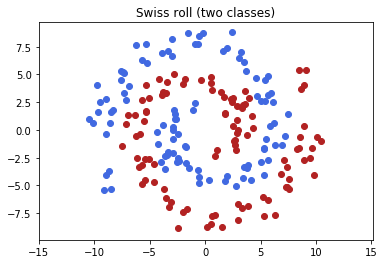

In [1]:
import tntorch as tn
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

N = 2
C = 2  # Number of classes
P = 100  # Points per class
c0 = torch.rand(P)*8+2
c0 = c0[:, None]
c0 = torch.cat([c0*torch.cos(c0), c0*torch.sin(c0)], dim=1)
c0 += torch.randn(*c0.shape)/1.5
c1 = -c0

plt.figure()
plt.scatter(c0[:, 0], c0[:, 1], color='royalblue')
plt.scatter(c1[:, 0], c1[:, 1], color='firebrick')
plt.gca().set_aspect('equal', 'datalim')
plt.title('Swiss roll (two classes)')
plt.show()

In [2]:
# Assemble (X, y) data set
X = torch.cat([c0, c1], dim=0)
y = torch.cat([torch.zeros(len(c0)), torch.ones(len(c1))])

# Shuffle data
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# Discretize features into [0, 1, ..., nticks-1]
nticks = 128
X = (X-X.min()) / (X.max()-X.min())
X = X*(nticks-1)

# Split into 75% train / 25% test
ntrain = int(len(X)*0.75)
X_train = X[:ntrain, :].long()
y_train = y[:ntrain].long()
X_test = X[ntrain:, :].long()
y_test = y[ntrain:].long()

Let's set up the $128 \times 128 \times 2$ tensor that will be optimized. We will use an expansion using low-frequency cosine wavefunctions:

In [3]:
t = tn.rand(shape=[nticks]*N + [C], ranks_tt=10, ranks_tucker=6, requires_grad=True)
t.set_factors('dct', dim=range(N))
t

3D TT-Tucker tensor:

 128 128  2
  |   |   |
  6   6   6
 (0) (1) (2)
 / \ / \ / \
1   10  10  1

Our tensor's last dimension is $2$: for each feature $(x_1, x_2)$ it produces $2$ numbers, one per class. For classification we will transform these weights into probabilities using the softmax function:

In [4]:
def softmax(x):
    expx = torch.exp(x-x.max())
    return expx / torch.sum(expx, dim=-1, keepdim=True)

To assess the goodness of a matrix of probabilities (rows are instances, columns are classes) we use the cross-entropy loss:

In [5]:
def cross_entropy_loss(probs, y):
    return torch.mean(-torch.log(probs[np.arange(len(probs)), y]))

We are now ready to fit our tensor network:

In [6]:
def loss(t):
    return cross_entropy_loss(softmax(t[X_train].torch()), y_train)
tn.optimize(t, loss)

iter: 0      | loss:   0.707212 | total time:    0.0022
iter: 500    | loss:   0.056675 | total time:    1.3520
iter: 1000   | loss:   0.006464 | total time:    2.7943
iter: 1500   | loss:   0.001936 | total time:    4.1302
iter: 2000   | loss:   0.000841 | total time:    5.5035
iter: 2500   | loss:   0.000438 | total time:    6.8394
iter: 3000   | loss:   0.000254 | total time:    8.1114
iter: 3500   | loss:   0.000157 | total time:    9.4423
iter: 4000   | loss:   0.000102 | total time:   10.7657
iter: 4026   | loss:   0.000100 | total time:   10.8177 <- converged (tol=0.0001)


We now predict classes for the test instances and compute the *score* (#correctly classified / number of test instances):

In [7]:
prediction = torch.max(t[X_test].torch(), dim=1)[1]
score = torch.sum(prediction == y_test).double() / len(y_test)
print('Score:', score)

Score: tensor(0.9400)


Finally, we will show the class probabilities for the whole feature space (blue is class `0`, red is class `1`):

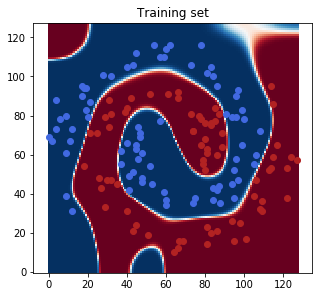

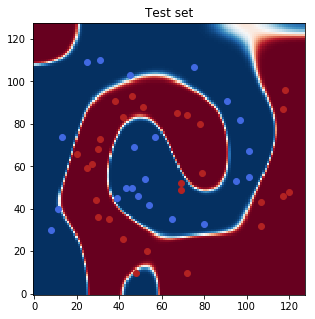

In [8]:
fig = plt.figure(figsize=(5, 5))
plt.title('Training set')
plt.imshow(softmax(t.torch())[..., 0].detach().numpy().T, origin='lower', cmap='RdBu')
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], color='royalblue')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], color='firebrick')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.title('Test set')
plt.imshow(softmax(t.torch())[..., 0].detach().numpy().T, origin='lower', cmap='RdBu')
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], color='royalblue')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='firebrick')
plt.show()